# Lab2: Classifier Implementation - Palmer Penguins 

## 1 About Dataset

![](image/Palmer.png)

Dataset Source: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data

### 1.1 Background

The goal of palmerpenguins is to provide a great dataset for data exploration & visualization, as an alternative to iris.

Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

### 1.2 Content

The palmerpenguins package contains two datasets.

One is called penguins_size, and is a simplified version of the raw data. The columns in this dataset are:

- species
- island
- culmen_length_mm
- culmen_depth_mm
- flipper_length_mm
- body_mass_g
- sex

The second dataset is penguins_Iter, and contains all the variables and original names as downloaded.

Both datasets contain data for 344 penguins. There are 3 different species of penguins in this dataset, collected from 3 islands in the Palmer Archipelago, Antarctica.

![](image/Penguins.png)

## 2 Data Preprocessing

Set up coding environment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
print("Setup Complete")

Setup Complete


Load and examine the data

In [2]:
df = pd.read_csv('data/penguins_size.csv')
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Check missing data

In [4]:
def check_missing_data(df):
    return df.isnull().sum().sort_values(ascending=False)

In [5]:
check_missing_data(df)

sex                  11
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
species               0
island                0
dtype: int64

We can find that the proportion of missing data is relatively small, so we can simply filter them out.

In [6]:
df = df.dropna()
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


In [7]:
df["species"].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

We can find that the dataset contains three penguins species, namely Adelie, Chinstrap and Gentoo. 

In [8]:
df["island"].value_counts()

Biscoe       163
Dream        123
Torgersen     47
Name: island, dtype: int64

We can also find that the data is collected from three islands, namely Biscoe, Dream and Torgersen.

Next, we replace the textual data with numerical data. Specifically, we replace (female, male) with (0, 1), (Adelie, Chinstrap, Gentoo) with (0, 1, 2), and (Biscoe, Dream, Torgersen) with (0, 1 , 2).

In [9]:
def create_data(df):
    data = df.replace({"sex": {"FEMALE": 0, "MALE": 1},
                       "species": {"Adelie": 0, "Chinstrap": 1, "Gentoo": 2}, 
                       "island": {"Biscoe": 0, "Dream": 1, "Torgersen": 2}})
    data = np.array(data.iloc[:, [2, 3, 4, 5, 6, 1, 0]])
    # print(data)
    return data[:, :-1], data[:, -1].astype('int64')

In [10]:
X, y = create_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 3 Classifier Implementation

In [11]:
class Node:
    def __init__(self, left, right, feature_lists, gini, split_feature, split_value, label):
        self.left = left
        self.right = right
        self.feature_lists = feature_lists
        self.gini = gini
        self.split_feature = split_feature
        self.split_value = split_value
        self.label = label

    def predict(self, X):
        if self.left != None and X[self.split_feature] <= self.split_value:
            return self.left.predict(X)
        elif self.right != None and X[self.split_feature] > self.split_value:
            return self.right.predict(X)
        else:
            return self.label

In [12]:
class CART:
    def __init__(self, gini_threshold=0.1):
        self.gini_threshold = gini_threshold
        self._tree = None

    def calc_gini(self, y):
        ret = 1
        D = len(y)
        for i in np.unique(y, return_counts=True)[1]:
            ret -= (i / D) ** 2
        return ret

    def train(self, X_train, y_train, feature_lists):
        if len(y_train) == 0: return None

        _gini = self.calc_gini(y_train)
        if len(feature_lists) == 0 or _gini <= self.gini_threshold:
            return Node(left=None, right=None, feature_lists=feature_lists, gini=_gini, split_feature=None, split_value=None, label=np.argmax(np.bincount(y_train)))

        min_gini = 1
        for index in feature_lists:
            for value in np.unique(X_train[:, index]):
                left_y = y_train[X_train[:, index] <= value]
                right_y = y_train[X_train[:, index] > value]
                left_gini = self.calc_gini(left_y)
                right_gini = self.calc_gini(right_y)
                split_gini = (len(left_y) / len(y_train)) * left_gini + (len(right_y) / len(y_train)) * right_gini
                if (split_gini < min_gini):
                    min_gini = split_gini
                    split_feature = index
                    split_value = value
                
        left_feature_lists = feature_lists.copy()
        left_feature_lists.remove(split_feature)
        right_feature_lists = feature_lists.copy()
        right_feature_lists.remove(split_feature)

        return Node(left=self.train(X_train[X_train[:, split_feature] <= split_value], y_train[X_train[:, split_feature] <= split_value], left_feature_lists),
                    right=self.train(X_train[X_train[:, split_feature] > split_value], y_train[X_train[:, split_feature] > split_value], right_feature_lists),
                    feature_lists=left_feature_lists,
                    gini=_gini,
                    split_feature=split_feature,
                    split_value=split_value,
                    label=np.argmax(np.bincount(y_train)))

    def fit(self, X, y):
        self.feature_dimension = X.shape[1]
        _feature_lists = list(range(self.feature_dimension))
        self._tree = self.train(X, y, _feature_lists)
        return self._tree

    def predict(self, x):
        return self._tree.predict(x)

    def score(self, X_test, y_test):
        n = len(y_test)
        correct = 0
        for i in range(n):
            if self.predict(X_test[i]) == y_test[i]:
                correct += 1
        return correct / n


In [13]:
model = CART(gini_threshold=0.02)
model.fit(X_train, y_train)

In [14]:
model.score(X_test, y_test)

0.98

## 4 Comparison with scikit-learn



In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [16]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train,)

DecisionTreeClassifier()

In [17]:
clf.score(X_test, y_test)

0.98

In [18]:
tree_pic = export_graphviz(clf, out_file="tree.dot", feature_names=["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm",	"body_mass_g", "sex", "island"])
with open("tree.dot") as f:
    dot_graph = f.read()

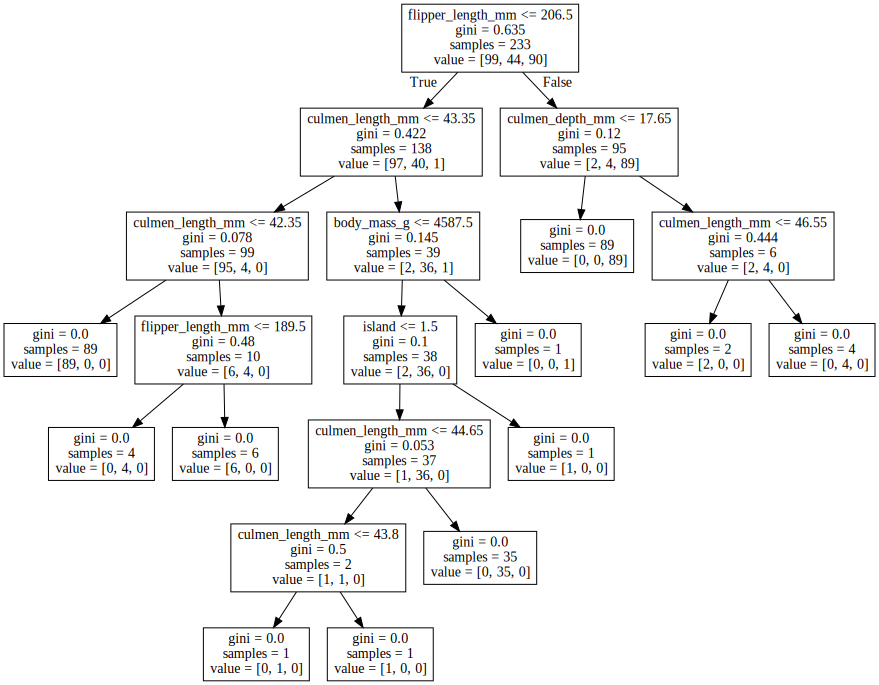

In [19]:
graphviz.Source(dot_graph)